<a href="https://colab.research.google.com/github/OtmaneDaoudi/Arabic-sentiment-analysis/blob/main/arabic_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

In [2]:
!pip install emoji
!pip install Arabic-Stopwords
!pip install seaborn
!pip install matplotlib
!pip install soyclustering


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Libs imports

In [58]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import gensim
import emoji
import arabicstopwords.arabicstopwords as stp
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from collections import defaultdict
from math import log

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')

SEED = 21

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing data

In [59]:
data = pd.read_csv("datasets/1/data.tsv", sep = '\t', header=None, names = ["class", "tweet"])
data = data.sample(frac=1, random_state = SEED)
data.head(20)

,class,tweet
25643,pos,سيارتي انظف من غرفة نومك صدقيني 😂
41387,pos,#النصر برجالو يحتزم💛💙 غزاني عليك الشوق والشوق ...
29251,pos,ويازينتس انتي بعد 😍
31138,pos,يارب الحدا الصح اللي اكمل معو حياتي هيك 🙏
31900,pos,قررت اتابع مسلسل هالحلو 😋
15976,neg,يقولوا 😏 الجميله الي تعرف تخبز خبز عماني ولا ا...
36687,pos,إذا سمعت أحد يقول : اللهم لا شماته ، تأكد انها...
33299,pos,يا هني السنين فيك يا ضياها 🎊
37287,pos,تواريخ الرحلات النسائية الى #النرويج مع مرشدة ...
15306,neg,الأب رجل مختلف في حياة كل فتاه ولو سألت كل فتا...


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45275 entries, 25643 to 15305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   45275 non-null  object
 1   tweet   45275 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


# Data preprocessing

Our preprocessing pipeline contains the following steps:

0.  Remove duplicat entries
1.  Replacing emojies & emoticons
2.  Remove mentions
3.  Remove Links
6.  Remove whitespaces
7.  Remove 'Harakat'
8.  Remove punctuations & Special chars
9.  Remove Consecutive characters
10.  Tokenization
11. Remove foreign words
12. Remove stop words
13. Remove numbers
14. Stemming

Optional Steps (Might be added if proven to give better output):
* Remove words with length less than THRESHOLD chars


## Removing duplicates

In [61]:
count = data.duplicated().sum()
print(f"{(count / data.shape[0]) * 100:.1f}% of the data are duplicats")

34.7% of the data are duplicats


In [62]:
data.drop_duplicates(inplace = True)

## Replacing emojies

In [63]:
emojis = {
    "🙂":"يبتسم",
    "😂":"يضحك",
    "🤣" : "يضحك",
    "💔":"قلب حزين",
    "🙂":"يبتسم",
    "❤️":"حب",
    "🥰":"حب",
    "🤐":"سكوت",
    "🧡":"حب",
    "❤":"حب",
    "😍":"حب",
    "😭":"يبكي",
    "🤭":"يبتسم",
    "😢":"حزن",
    "😔":"حزن",
    "♥":"حب",
    "💜":"حب",
    "😅":"يضحك",
    "🙁":"حزين",
    "💕":"حب",
    "💙":"حب",
    "😞":"حزين",
    "😊":"سعادة",
    "👏":"يصفق",
    "👌":"احسنت",
    "😴":"ينام",
    "😀":"يضحك",
    "✅":"صحيح",
    "🤪":"يضحك",
    "🏡" : "بيت",
    "🤲" : "دعاء",
    "💰" : "مال",
    "😌":"حزين",
    "🎁":"هدية",
    "🌹":"وردة",
    "🥀":"وردة",
    "📿":"وردة",
    "✍":"كتابة",
    "🙈":"حب",
    "😄":"يضحك",
    "😐":"محايد",
    "✌":"منتصر",
    "✨":"نجمه",
    "🤔":"تفكير",
    "😏":"يستهزء",
    "😒":"يستهزء",
    "🙄":"ملل",
    "😕":"عصبية",
    "😃":"يضحك",
    "🌸":"وردة",
    "😓":"حزن",
    "💞":"حب",
    "💗":"حب",
    "😑":"منزعج",
    "💭":"تفكير",
    "😎":"ثقة",
    "💛":"حب",
    "😩":"حزين",
    "🥺":"حزين",
    "💪":"عضلات",
    "👍":"موافق",
    "🙏🏻":"رجاء طلب",
    "😳":"مصدوم",
    "👏🏼":"تصفيق",
    "🎶":"موسيقي",
    "🌚":"صمت",
    "💚":"حب",
    "🙏":"رجاء طلب",
    "💘":"حب",
    "🍃":"سلام",
    "☺":"يضحك",
    "🎊":"يهنئ",
    "💥":"إنفجار",
    "😝":"يسخر",
    "💯":"تمام",
    "🐸":"ضفدع",
    "🤦‍♂️":"غبي",
    "🤩":"معجب",
    "🤤":"جائع",
    "😶":"مصدوم",
    "✌️":"مرح",
    "✋🏻":"توقف",
    "😉":"غمزة",
    "🌷":"حب",
    "🙃":"مبتسم",
    "😫":"حزين",
    "😨":"مصدوم",
    "🎼 ":"موسيقي",
    "🍁":"مرح",
    "🍂":"مرح",
    "💟":"حب",
    "😪":"حزن",
    "😆":"يضحك",
    "😣":"استياء",
    "☺️":"حب",
    "😱":"كارثة",
    "😁":"يضحك",
    "😖":"استياء",
    "🏃🏼":"يجري",
    "😡":"غضب",
    "🚶":"يسير",
    "🤕":"مرض",
    "🤮" : "يتقيئ",
    "⛔": "حذر",
    "‼️":"تعجب",
    "🕊":"طائر",
    "👌🏻":"احسنت",
    "❣":"حب",
    "🙊":"مصدوم",
    "💃":"سعادة مرح",
    "💃🏼":"سعادة مرح",
    "😜":"مرح",
    "👊":"ضربة",
    "😟":"استياء",
    "💖":"حب",
    "😥":"حزن",
    "🎻":"موسيقي",
    "✒":"يكتب",
    "🚶🏻":"يسير",
    "💎":"الماظ",
    "😷":"وباء مرض",
    "☝":"واحد",
    "🚬":"تدخين",
    "💐" : "ورد",
    "🌻" : "ورد",
    "🌞" : "شمس",
    "👆" : "الاول",
    "⚠️" :"تحذير",
    "🤗" : "احتواء",
    "✖️": "غلط",
    "📍"  : "مكان",
    "👸" : "ملكه",
    "👑" : "تاج",
    "✔️" : "صح",
    "💌": "قلب",
    "😲" : "مندهش",
    "💦": "ماء",
    "🚫" : "خطا",
    "👏🏻" : "برافو",
    "🏊" :"يسبح",
    "👍🏻": "تمام",
    "⭕️" :"دائره كبيره",
    "🎷" : "ساكسفون",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝":"مبتسم",
    "➿"  : "عقده مزدوجه",
    "💪🏼" : "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧" : "قلق و صدمة",
    "🗨": "رسالة",
    "❗️" :"تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯" :"اخوات",
    "©" :  "رمز",
    "👵🏽" :"سيده عجوزه",
    "🐣": "كتكوت",
    "🙌": "تشجيع",
    "🙇": "شخص ينحني",
    "👐🏽":"ايدي مفتوحه",
    "👌🏽": "بالظبط",
    "⁉️" : "استنكار",
    "⚽️": "كوره",
    "🕶" :"حب",
    "🎈" :"بالون",
    "🎀":    "ورده",
    "💵":  "فلوس",
    "😋":  "جائع",
    "😛":  "يغيظ",
    "😠":  "غاضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",
    "👣":  "اثر قدمين",
    "❌":"رفض",
    "🍟":"طعام",
    "👬":"صداقة",
    "🐰":"ارنب",
    "🦋" : "فراشة",
    "☂":"مطر",
    "⚜":"مملكة فرنسا",
    "🐑":"خروف",
    "🗣":"صوت مرتفع",
    "👌🏼":"احسنت",
    "☘":"مرح",
    "😮":"صدمة",
    "😦":"قلق",
    "⭕":"الحق",
    "✏️":"قلم",
    "ℹ":"معلومات",
    "🙍🏻":"رفض",
    "⚪️":"نضارة نقاء",
    "🐤":"حزن",
    "💫":"مرح",
    "💝":"حب",
    "🍔":"طعام",
    "❤︎":"حب",
    "✈️":"سفر",
    "🏃🏻‍♀️":"يسير",
    "🍳":"ذكر",
    "🎤":"مايك غناء",
    "🎾":"كره",
    "🐔":"دجاجة",
    "🙋":"سؤال",
    "📮":"بحر",
    "💉":"دواء",
    "🙏🏼":"رجاء طلب",
    "💂🏿 ":"حارس",
    "🎬":"سينما",
    "♦️":"مرح",
    "💡":"قكرة",
    "‼":"تعجب",
    "👼":"طفل",
    "🔑":"مفتاح",
    "♥️":"حب",
    "🌲" : "شجرة",
    "🌳" : "شجرة",
    "🚩" : "حذر",
    "🚨" : "حذر",
    "🛑" : "حذر",
    "🕋":"كعبة",
    "🐓":"دجاجة",
    "💩":"معترض",
    "👽":"فضائي",
    "☔️":"مطر",
    "🍷":"عصير",
    "🌟":"نجمة",
    "☁️":"سحب",
    "👃":"معترض",
    "🌺":"مرح",
    "🔪":"سكينة",
    "♨":"سخونية",
    "👊🏼":"ضرب",
    "✏":"قلم",
    "🚶🏾‍♀️":"يسير",
    "👊":"ضربة",
    "◾️":"وقف",
    "😚":"حب",
    "🔸":"مرح",
    "👎🏻":"لا يعجبني",
    "👊🏽":"ضربة",
    "😙":"حب",
    "🎥":"تصوير",
    "👉":"جذب انتباه",
    "👏🏽":"يصفق",
    "💪🏻":"عضلات",
    "🏴":"اسود",
    "🔥":"حريق",
    "😬":"عدم الراحة",
    "👊🏿":"يضرب",
    "📚" : "كتب",
    "📌" : "علق",
    "🌿":"ورقه شجره",
    "✋🏼":"كف ايد",
    "👐":"ايدي مفتوحه",
    "☠️":"وجه مرعب",
    "🎉":"يهنئ",
    "🔕" :"صامت",
    "😿":"وجه حزين",
    "☹️":"وجه يائس",
    "😘" :"حب",
    "😰" :"خوف و حزن",
    "🌼":"ورده",
    "💋": "بوسه",
    "👇":"لاسفل",
    "❣️":"حب",
    "🎧":"سماعات",
    "📝":"يكتب",
    "😇":"دايخ",
    "😈":"رعب",
    "🏃":"يجري",
    "✌🏻":"علامه النصر",
    "🔫":"يضرب",
    "❗️":"تعجب",
    "👎":"غير موافق",
    "🔐":"قفل",
    "👈":"لليمين",
    "™":"رمز",
    "🚶🏽":"يتمشي",
    "😯":"متفاجأ",
    "✊":"يد مغلقه",
    "😻":"اعجاب",
    "🙉" :"قرد",
    "👧":"طفله صغيره",
    "🔴":"دائره حمراء",
    "💪🏽":"قوه",
    "💤":"ينام",
    "👀":"ينظر",
    "✍🏻":"يكتب",
    "❄️":"تلج",
    "💀":"رعب",
    "😤":"وجه عابس",
    "🖋":"قلم",
    "🎩":"كاب",
    "☕️":"قهوه",
    "😹":"ضحك",
    "💓":"حب",
    "☄️":"نار",
    "👻":"رعب",
    "✋": "يد",
    "🌱": "نبتة",

    # Emoticons
    ":)" : "يبتسم",
    "(:" : "يبتسم",
    ":(" : "حزين",
    "xD" : "يضحك",
    ":=(": "يبكي",
    ":'(": "حزن",
    ":'‑(": "حزن",
    "XD" : "يضحك",
    ":D" : "يبتسم",
    "♬" : "موسيقي",
    "♡" : "حب",
    "☻"  : "يبتسم",
}

def replace_emojis(text):
    pattern = re.compile('|'.join(re.escape(key) for key in emojis.keys()))
    replaced_text = pattern.sub(lambda match: emojis[match.group(0)] + ' ', text)
    return emoji.replace_emoji(replaced_text, '')

data["tweet"] = data["tweet"].apply(lambda document: replace_emojis(document))

## Removing mentions

In [64]:
pattern = r'@[\w]+'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Removing links

In [65]:
pattern = r'https?://\S+'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Removing hashtags

In [66]:
pattern = r'#([\w\u0600-\u06FF]+)'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Removing whitespaces
In this step we get rid of extra whitespaces as well as new lines

In [67]:
pattern = r'\s+|\n+'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, ' ', document))

## Remove foriegn words

The text includes english, japanese and words for other languages

In [68]:
pattern = r'[a-zA-Z]+'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Remove punctuations & special chars

In [69]:
pattern = r'[^\w\s\u0600-\u06FF]+|ﷺ|۩|⓵|؟|۞|ﷻ'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Remove consecutive characters

In [70]:
pattern = r'(.)\1+'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, r'\1', document))

## Removing numbers

In [71]:
pattern = r'\d+'
data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

# Tokenization

In [72]:
tokenizer = TweetTokenizer()
data["tweet"] = data["tweet"].apply(lambda document: tokenizer.tokenize(document))
data["tweet"] = data["tweet"].apply(lambda document: " ".join(document).strip())

In [73]:
data.tail(3)

,class,tweet
23228,pos,و كل م يأتي من الہ جميل ف الحمدلهہ دائما مسآء ...
16432,neg,حين تعتاد على محادثة شخص تحبه دوما كل يوم فإن ...
8964,neg,تعبت ولا نبي نتعلم ولانتخرج اكتفيت يد


## Stemming


In [74]:
stemmer = ISRIStemmer()

def stem_document(document):
    words = document.split(sep = ' ')
    return " ".join([stemmer.stem(word) for word in words])

data['tweet'] = data["tweet"].apply(lambda document: stem_document(document))

## Removing stop words

In [75]:
arabic_stopwords = stopwords.words('arabic')
arabic_stopwords.extend(stp.stopwords_list())
stop_words = {entry for entry in arabic_stopwords}

with open("arabic_stopwords.txt", "r", encoding="UTF-8") as file:
    for word in file:
        stop_words.add(stemmer.stem(word.strip()))
stop_words

{'ووراءنا',
 'وأقلكن',
 'فكمثلهما',
 'أفذي',
 'ولتلقاءهن',
 'فأخيكم',
 'أفلنفس',
 'وبأكثركم',
 'وجنوبه',
 'أفليميني',
 'يورو',
 'لكنك',
 'وراءك',
 'فبأخيهن',
 'التي',
 'كنحوها',
 'فلعينهما',
 'أفعليه',
 'ألأمامهن',
 'فكشرقنا',
 'ولمعكن',
 'لرجع',
 'بجميعكما',
 'وبشرقكن',
 'أولديها',
 'أولكل',
 'وبحسبه',
 'أبأولاء',
 'كأخيهما',
 'ومثلكم',
 'هذا',
 'وحولهم',
 'أولأناي',
 'الألاء',
 'زماننا',
 'فلخلفنا',
 'أولسواهما',
 'فكحميكن',
 'أوأجمعنا',
 'فكزمانه',
 'لئن',
 'فابنكما',
 'فلكأنه',
 'كوقتكن',
 'وبينما',
 'أفلعينهما',
 'فكتلقائهن',
 'فكإن',
 'أأجمعها',
 'أبنحوكم',
 'أوبنحو',
 'شمالها',
 'فمعاذ',
 'مازلن',
 'بتلقائه',
 'أفكمثلهم',
 'فبشهري',
 'فلغيرهم',
 'فللحظتها',
 'أفأناكما',
 'ككليهما',
 'لحميهن',
 'فعن',
 'وأثناءهما',
 'فعامته',
 'فكجنوبها',
 'أفلنحوكن',
 'لأخيهما',
 'أولجميعكم',
 'نيسان',
 'نحوها',
 'أوبسواكما',
 'بأقلنا',
 'فبذاتي',
 'ويكأنك',
 'فبشبهها',
 'إنما',
 'فلان',
 'فلأمسى',
 'أوبعامة',
 'وأصلا',
 'صرح',
 'ولكأنها',
 'فأخيه',
 'لفوقنا',
 'وبنحوكن',
 'ويكأنهم',
 'أسواهم',


In [76]:
def remove_stop_words(tweet: str) -> str:
    words = set(tweet.split(sep = ' '))
    return " ".join(list((words - stop_words)))

data["tweet"] = data["tweet"].apply(lambda document: remove_stop_words(document))

In [23]:
data.to_csv("res.csv") # inspect the resulting file to validate the preprocessing

# Text representation

## BoW (Bag-of-Words)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size = 0.2, random_state = SEED, stratify= data["class"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

X_train[0].shape

(15514,)

### Performance evaluation
#### Naive bayes

In [78]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 56.45%


#### Logistic regression

In [81]:
model = LogisticRegression(max_iter = 2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 86.77%


#### SVM

We were unable to train this model on our machines using the initial dataset, due to the **curse of dimensionality**, so we added dimensioanlity reduction

In [ ]:
scaler = StandardScaler()
svm = SVC()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

componenets = [100, 200, 500]
scores = []
for n_components in componenets:
    pca = PCA(n_components = n_components)
    X_train_SVM = pca.fit_transform(scaled_X_train)
    X_test_SVM  = pca.transform(scaled_X_test)

    svm.fit(X_train_SVM, y_train)
    y_pred = svm.predict(X_test_SVM)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

plt.plot(componenets, scores)
plt.xlabel('# of componenets')
plt.ylabel('Accuracy')
plt.show()

#### Random forest

In [85]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy * 100:.2f}%")

Random Forest accuracy: 86.28%


## TF-IDF

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size = 0.2, random_state = SEED, stratify= data["class"])

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

X_train[0].shape

(15514,)

### Performance evaluation
#### Naive bayes

In [89]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 58.32%


#### Logistic regression

In [90]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 87.01%


#### SVM

In [96]:
scaler = StandardScaler()
pca = PCA(n_components = 200)
svm = SVC()

X_train_SVM = pca.fit_transform(scaler.fit_transform(X_train.copy()))
X_test_SVM = pca.transform(scaler.transform(X_test.copy()))

y_train_SVM = y_train
y_test_SVM = y_test

svm.fit(X_train_SVM, y_train_SVM)
y_pred = svm.predict(X_test_SVM)
accuracy = accuracy_score(y_test_SVM, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 58.77%


#### Random Forest

In [91]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy * 100:.2f}%")

Random Forest accuracy: 86.80%


## LDA

In [92]:
lda = LatentDirichletAllocation(n_components = 100, random_state = SEED)
X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)

model = LogisticRegression(max_iter = 1000)
model.fit(X_train_lda, y_train)
y_pred = model.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 63.22%


## LSA

In [94]:
lsa = TruncatedSVD(n_components = 10, random_state = SEED)
X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.transform(X_test)
model = LogisticRegression(max_iter = 1000)
model.fit(X_train_lsa, y_train)
y_pred = model.predict(X_test_lsa)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.00%


## BoC (Bag-of-concepts)

The BOC (Bag-of-Concepts) method has been proposed as a solution to the problem of large dimensions and sparsity that traditional methods such as TF-IDF and Bag of words suffer from.

## Word embeddings
This is done using the AraVec model which is trained on arabic tweets

In [95]:
model = gensim.models.Word2Vec.load("./aravec/tweets_cbow_300")
word_vecs = {}
for tweet in data["tweet"]:
    for word in tweet.split(" "):
        try:
            word_vecs[word] = model.wv[word]
        except Exception:
            pass

## Clustering the words embeddings
This is done in order to extract concepts, using a variant of KMeans called spherical KMeans which uses cosine similarity, making it well suited for this task

In [50]:
NUM_CONCEPTS = 80

model = KMeans(n_clusters = NUM_CONCEPTS)
X = list(word_vecs.values())
model.fit(X)
concepts = model.predict(X)


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Concept extraction
Now that we related words to concepts, we can create a document representataion, in which we express the degree of which a document contains a certain concept, and instead of taking only the freuqncies, we consider an approach similar to TF-IDF called, CF-IDF.

CF-IDF is defined using the following formula : 

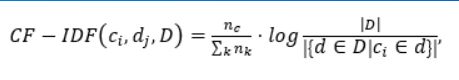


such that : 

    * |D| is the number of documents in the corpus
    * n_c is the number of occurences of concept c in document d
    * n_k is the total number of concepts in this document 

In [51]:
NUM_DOCS = data.shape[0]

# construct a word to concept mapping
word_concept = {}
for index, word in enumerate(word_vecs.keys()):
    word_concept[word] = concepts[index]
print(word_concept)

{'غرف': 4, 'نظف': 74, 'يضح': 68, 'صدق': 27, 'نوم': 48, 'سير': 4, 'شوق': 48, 'وجد': 33, 'وتم': 17, 'غزا': 43, 'حب': 48, 'احب': 13, 'وله': 7, 'مسه': 33, 'نرح': 79, 'رجلو': 67, 'جيت': 21, 'انت': 48, 'هيك': 38, 'كمل': 5, 'طلب': 17, 'حدا': 38, 'يرب': 68, 'معو': 38, 'حيت': 7, 'سلسل': 79, 'قرت': 20, 'هالحلو': 79, 'تبع': 67, 'بقي': 14, 'صمت': 18, 'خبز': 23, 'غمز': 5, 'عرف': 33, 'يقل': 40, 'عما': 31, 'شرش': 79, 'جمل': 74, 'هزء': 79, 'شمت': 7, 'بسم': 74, 'لهم': 77, 'سمع': 33, 'ايد': 9, 'لحم': 23, 'كف': 48, 'شحم': 62, 'سنن': 47, 'هني': 27, 'ضيا': 18, 'هنئ': 79, 'ادر': 11, 'خلج': 58, 'رحل': 33, 'طار': 21, 'رشد': 6, 'نسي': 33, 'فته': 23, 'رجل': 62, 'حزن': 48, 'خلف': 4, 'لقل': 68, 'قلب': 48, 'اله': 52, 'وفق': 8, 'شاء': 29, 'طيب': 27, 'شري': 7, 'ورد': 18, 'فرح': 18, 'نفس': 72, 'دائ': 1, 'مرض': 64, 'ويت': 1, 'فرق': 64, 'الن': 1, 'ونا': 27, 'هلل': 79, 'اهل': 57, 'اشف': 8, 'برا': 27, 'طبع': 48, 'لخص': 67, 'نقط': 67, 'داي': 1, 'كدا': 14, 'ظلم': 47, 'كنت': 13, 'شعر': 48, 'مطر': 18, 'واسترجاع': 79, 'صنع': 

In [52]:
# construct a concept to document count mapping
concept_docs = defaultdict(int)
for doc in data["tweet"]:
    doc_concepts = set()
    for word in doc.split(" "):
        try:
            doc_concepts.add(word_concept[word])
        except Exception:
            pass
    for concept in doc_concepts:
        concept_docs[concept] += 1
print(concept_docs)

defaultdict(<class 'int'>, {4: 4158, 68: 10812, 74: 6002, 48: 15777, 27: 4365, 33: 5179, 67: 3150, 7: 6141, 43: 6902, 13: 3980, 79: 9888, 17: 3648, 21: 2298, 5: 4304, 38: 1600, 20: 1631, 40: 3840, 14: 2924, 18: 6096, 23: 3245, 31: 170, 9: 1805, 77: 1389, 62: 2948, 47: 8925, 6: 6254, 11: 373, 58: 983, 8: 2159, 52: 3300, 29: 286, 1: 2740, 72: 4445, 64: 7213, 57: 1991, 24: 1182, 56: 1643, 49: 1977, 3: 1978, 54: 680, 22: 285, 32: 2427, 51: 211, 45: 1919, 50: 3131, 39: 110, 0: 1629, 12: 752, 16: 360, 35: 60, 2: 548, 42: 47, 53: 815, 59: 57, 75: 179, 70: 414, 19: 318, 63: 118, 66: 142, 30: 198, 26: 241, 34: 132, 61: 16, 73: 289, 76: 13, 36: 154, 41: 16, 69: 20, 28: 43, 55: 28, 46: 17, 44: 8, 15: 10, 37: 15, 60: 8, 78: 6, 71: 2, 65: 1, 10: 1, 25: 1})


In [53]:
def cf_idf(document: str):
    """ Returns the CD-IDF representataion of a document """
    res = [0 for _ in range(NUM_CONCEPTS)]
    concepts_counts = defaultdict(int)
    for word in document.split(" "):
        try:
            concepts_counts[word_concept[word]] += 1
        except:
            pass
    n_k = sum(concepts_counts.values()) # number of concepts present in the document (duplicates are considered!)
    for concept in range(NUM_CONCEPTS):
        if concepts_counts[concept] != 0:
            res[concept] = (concepts_counts[concept] / n_k) * log(NUM_DOCS / (1 + concept_docs[concept]))
    return res

In [54]:
X = [cf_idf(tweet) for tweet in data["tweet"]]
y = data["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

## Performance evaluation
### Naive bayes

In [55]:
model = GaussianNB()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 55.17%


## Logistic regression

In [56]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 64.42%


## SVM

In [57]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 65.20%
